<a href="https://colab.research.google.com/github/Abbta/adlfpae/blob/main/Exercise_7_1_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tabulate import tabulate
layers = tf.keras.layers

The code block below defines a few helper functions to visualize the results. You do not need to touch them.

In [3]:
def plot_examples(X, Y, n=10):
    """ Plot the first n examples for each of the 10 classes in the CIFAR dataset X, Y """
    fig, axes = plt.subplots(n, 10, figsize=(10, n))
    for l in range(10):
        axes[0, l].set_title(cifar10_labels[l], fontsize="smaller")
        m = np.squeeze(Y) == l  # boolean mask: True for all images of label l
        for i in range(n):
            image = X[m][i].astype("uint8")  # imshow expects uint8
            ax = axes[i, l]
            ax.imshow(image, origin="upper")
            ax.set(xticks=[], yticks=[])
    return fig, ax


def plot_prediction(X, Y, Y_predict):
    """
    Plot image X along with predicted probabilities Y_predict.
    X: CIFAR image, shape = (32, 32, 3)
    Y: CIFAR label, one-hot encoded, shape = (10)
    Y_predict: predicted probabilities, shape = (10)
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

    # plot image
    ax1.imshow(X.astype("uint8"), origin="upper")
    ax1.set(xticks=[], yticks=[])

    # plot probabilities
    ax2.barh(np.arange(10), Y_predict, align="center")
    ax2.set(xlim=(0, 1), xlabel="Score", yticks=[])
    for i in range(10):
        c = "red" if (i == np.argmax(Y)) else "black"
        ax2.text(0.05, i, cifar10_labels[i].capitalize(), ha="left", va="center", color=c)



def plot_confusion(Y_true, Y_predict):
    """
    Plot confusion matrix
    Y_true:    array of true classifications (0-9), shape = (N)
    Y_predict: array of predicted classifications (0-9), shape = (N)
    """
    C = np.histogram2d(Y_true, Y_predict, bins=np.linspace(-0.5, 9.5, 11))[0]
    Cn = C / np.sum(C, axis=1)

    fig = plt.figure()
    plt.imshow(Cn, interpolation="nearest", vmin=0, vmax=1, cmap=plt.cm.YlGnBu)
    plt.colorbar()
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.xticks(range(10), cifar10_labels, rotation="vertical")
    plt.yticks(range(10), cifar10_labels)
    for x in range(10):
        for y in range(10):
            plt.annotate("%i" % C[x, y], xy=(y, x), ha="center", va="center")



First we load and preprocess CIFAR-10 data. The imagages are 32x32 pixels and have three color channels (red, green blue).

In [4]:

# X: images, Y: labels
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print("images, shape = ", x_train.shape)
print("labels, shape = ", y_train.shape)

cifar10_labels = np.array([
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'])

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
images, shape =  (50000, 32, 32, 3)
labels, shape =  (50000, 1)


(<Figure size 1000x1000 with 100 Axes>, <Axes: >)

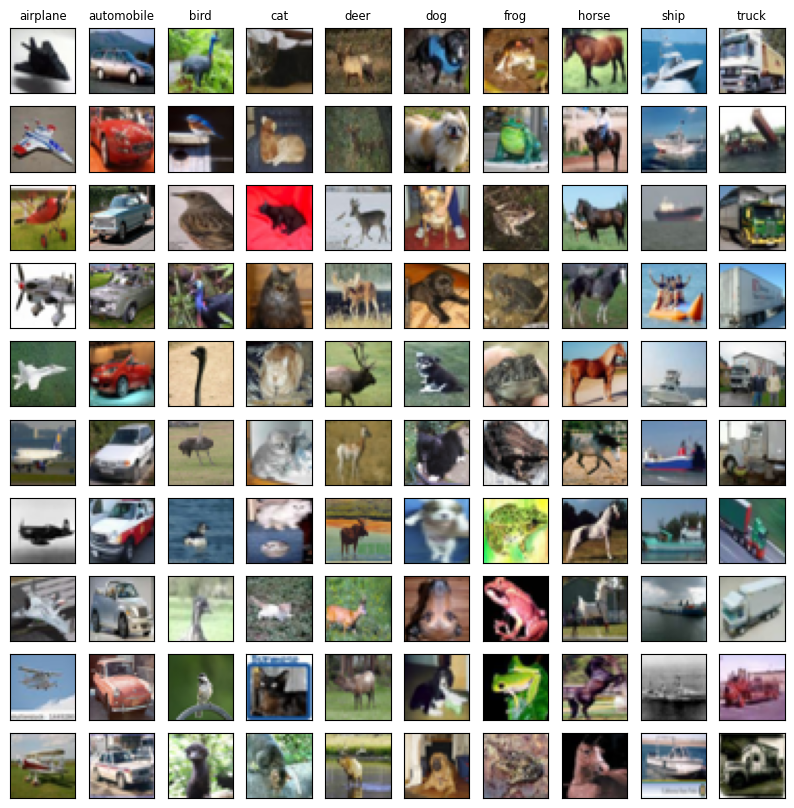

In [5]:
# Hint: To plot example images, you can use the plot examples function
plot_examples(x_train, y_train)

In [6]:
print(y_test.shape)

(10000, 1)


In [6]:
# convert labels ("0"-"9") to one-hot encodings, "0" = (1, 0, ... 0) and so on
y_train_onehot = tf.keras.utils.to_categorical(y_train, 10)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 10)[:8000]
y_valid_onehot = tf.keras.utils.to_categorical(y_test, 10)[8000:]

# Hint: normalize the data
x_train_norm = (x_train-np.mean(x_train)) / np.std(x_train)
x_test_norm = (x_test-np.mean(x_test)) / np.std(x_test)

# Hint: use 20% of the training data for validation
x_valid_norm=x_test_norm[8000:]
x_test_norm=x_test_norm[:8000]

We start with a fully connected network

In [7]:
# ----------------------------------------------------------
# Define model
# ----------------------------------------------------------
model = tf.keras.models.Sequential(
    [
        layers.Flatten(input_shape=(32, 32, 3)),  # (32,32,3) --> (3072)
        # this time the flatten operation is directly integrated into the network
        # structure so that we can use the same input data later for a convolutional neural network.
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.1),
        layers.Dense(256, activation="relu"),
        # Hint: remember that the output layer should have 10 nodes with a softmax activation
        layers.Dense(10, activation="softmax")
    ],
    name="nn",
)

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "nn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 3072)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         786,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 855,050 (3.26 MB)

 Trainable params: 855,050 (3.26 MB)

 Non-trainable params: 0 (0.00 B)

None


In [8]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"]
)

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=1000,
    epochs=20, # train at least for 20 epochs
    verbose=2,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
50/50 - 6s - 124ms/step - accuracy: 0.3722 - loss: 1.8178 - val_accuracy: 0.4420 - val_loss: 1.5920
Epoch 2/20
50/50 - 4s - 80ms/step - accuracy: 0.4669 - loss: 1.5197 - val_accuracy: 0.4685 - val_loss: 1.4866
Epoch 3/20
50/50 - 7s - 137ms/step - accuracy: 0.5050 - loss: 1.4160 - val_accuracy: 0.4845 - val_loss: 1.4619
Epoch 4/20
50/50 - 4s - 80ms/step - accuracy: 0.5287 - loss: 1.3436 - val_accuracy: 0.4805 - val_loss: 1.4258
Epoch 5/20
50/50 - 4s - 82ms/step - accuracy: 0.5525 - loss: 1.2825 - val_accuracy: 0.5150 - val_loss: 1.4125
Epoch 6/20
50/50 - 6s - 110ms/step - accuracy: 0.5758 - loss: 1.2189 - val_accuracy: 0.5095 - val_loss: 1.3913
Epoch 7/20
50/50 - 4s - 80ms/step - accuracy: 0.5934 - loss: 1.1687 - val_accuracy: 0.5155 - val_loss: 1.3758
Epoch 8/20
50/50 - 6s - 113ms/step - accuracy: 0.6092 - loss: 1.1304 - val_accuracy: 0.5095 - val_loss: 1.3994
Epoch 9/20
50/50 - 5s - 99ms/step - accuracy: 0.6255 - loss: 1.0850 - val_accuracy: 0.5160 - val_loss: 1.3862
Epoch 

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
0.542375


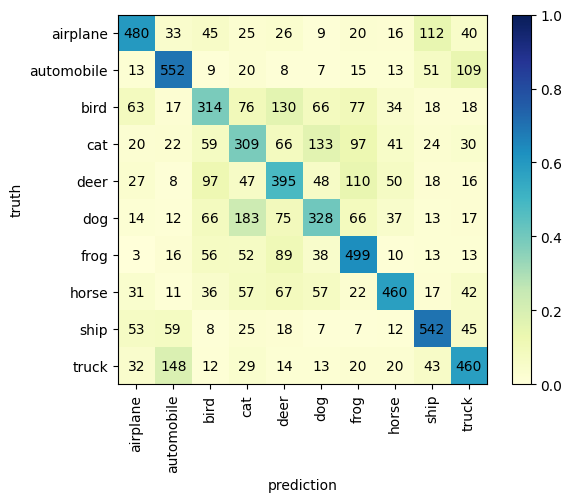

In [9]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)


# Hint: this is how you can plot the confusion matrix.
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

#
test_acc=np.mean(np.equal(y_predict_cl, y_test_cl))
print(test_acc)

Text(0, 0.5, 'Accuracy')

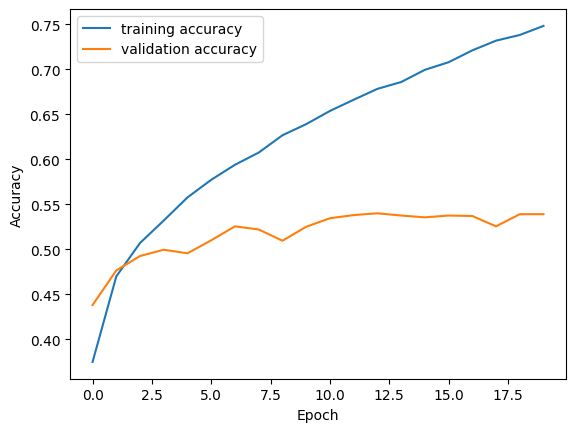

In [19]:
plt.figure()
plt.plot(history["epoch"], history["accuracy"], label="training accuracy")
plt.plot(history["epoch"], history["val_accuracy"], label="validation accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

## Answer:
Training accuracy: 75%, validation accuracy: 54%, test accuracy: 53%.

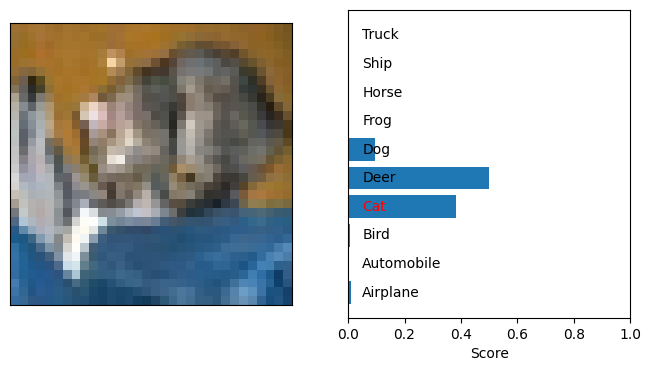

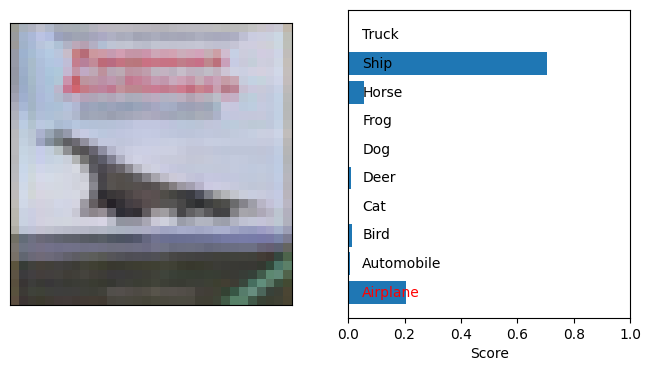

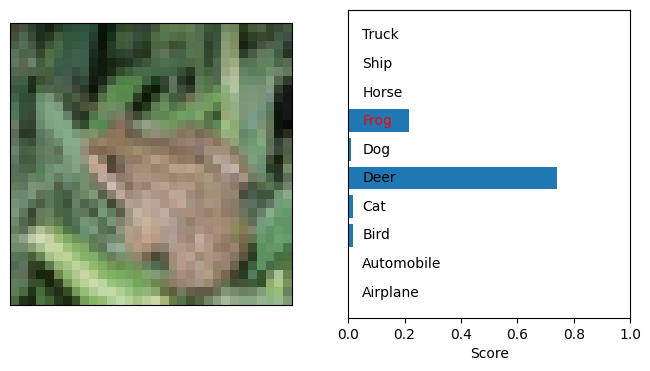

In [ ]:
# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
i0 = np.argwhere(y_predict_cl != y_test_cl)  # misclassified images
i1 = np.argwhere(y_predict_cl == y_test_cl)  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 3 false classifications
for i in i0[0:3]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

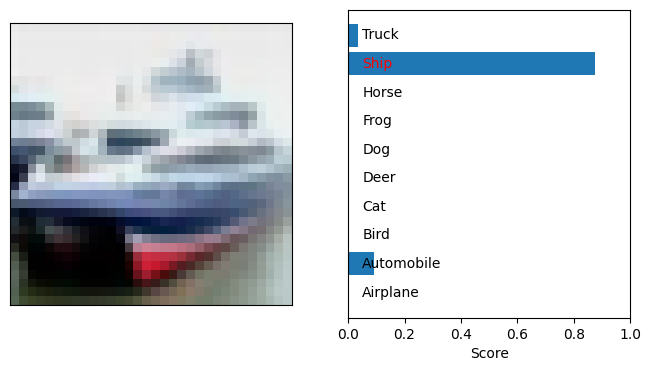

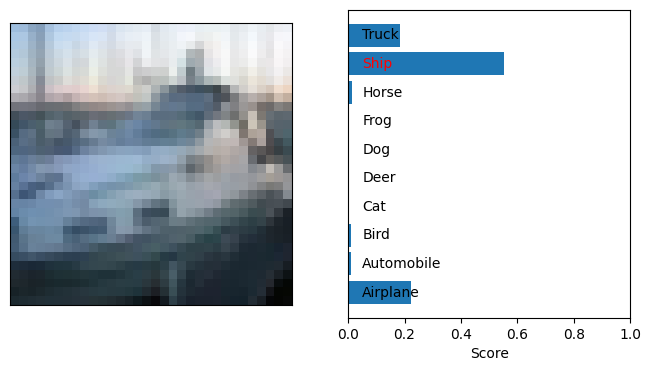

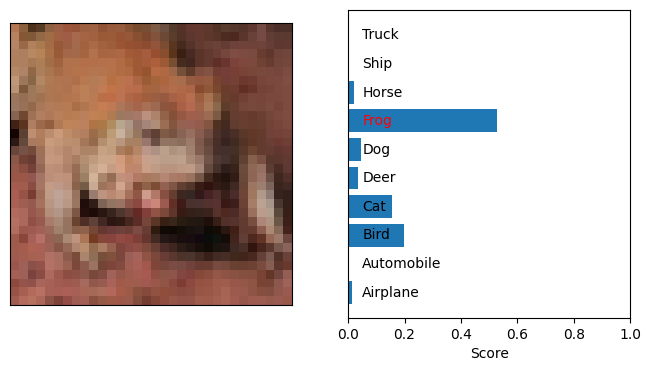

In [22]:
#Plot correct classifications:
for i in i1[0:3]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

**CNN**
In the second part of this exercise, classify the images with a CNN.


In [10]:
# Hint: this code snipped shows how to define convolution and maxpooling layers. For more information see
# https://keras.io/api/layers/convolution_layers/convolution2d/
# https://keras.io/api/layers/pooling_layers/max_pooling2d/
model = tf.keras.models.Sequential(
    [
        layers.Conv2D(16, kernel_size=(3, 3), padding="valid", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2), strides=(2,2)),
        layers.Conv2D(32, kernel_size=(3, 3), padding="valid", activation="relu", input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2,2), strides=(2,2)),
        layers.Flatten(),
        layers.Dense(10, activation="softmax")
    ],
    name="cnn",
)

print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │          11,530 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,618 (64.91 KB)

 Trainable params: 16,618 (64.91 KB)

 Non-trainable params: 0 (0.00 B)

None


In [11]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss='categorical_crossentropy',
    optimizer="adam",
    metrics=["accuracy"]
)

model.fit(
    x_train_norm, y_train_onehot,
    batch_size=2000,
    epochs=20, # train at least for 20 epochs
    verbose=1,
    validation_data=(x_valid_norm, y_valid_onehot),
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.1858 - loss: 2.1984 - val_accuracy: 0.3470 - val_loss: 1.8029
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.3774 - loss: 1.7506 - val_accuracy: 0.4220 - val_loss: 1.6343
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4359 - loss: 1.5899 - val_accuracy: 0.4555 - val_loss: 1.5393
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.4763 - loss: 1.4875 - val_accuracy: 0.4855 - val_loss: 1.4644
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5016 - loss: 1.4155 - val_accuracy: 0.5025 - val_loss: 1.4140
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5228 - loss: 1.3629 - val_accuracy: 0.5130 - val_loss: 1.3740
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - accuracy: 0.5421 - loss: 1.3176 - val_accuracy: 0.5270 - val_loss: 1.3410
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5541 - loss: 1.2751 - val_accuracy: 0.5400 - val_loss:

63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step
0.622


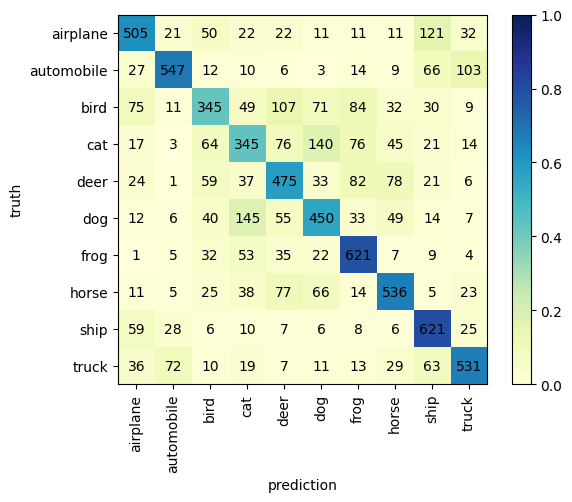

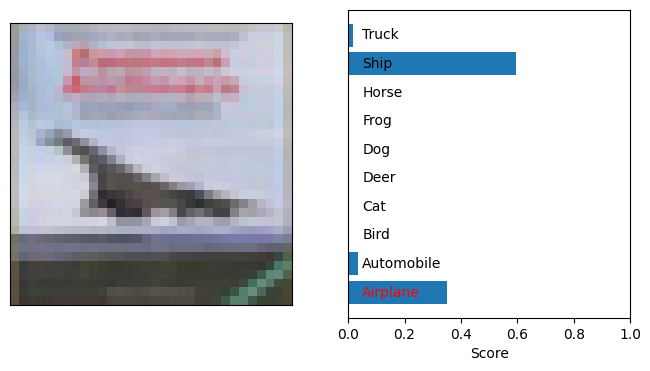

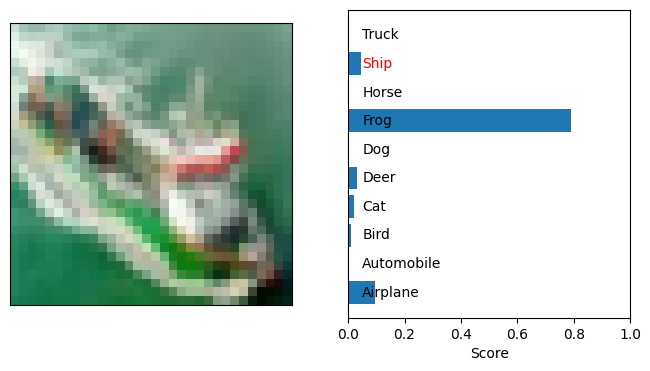

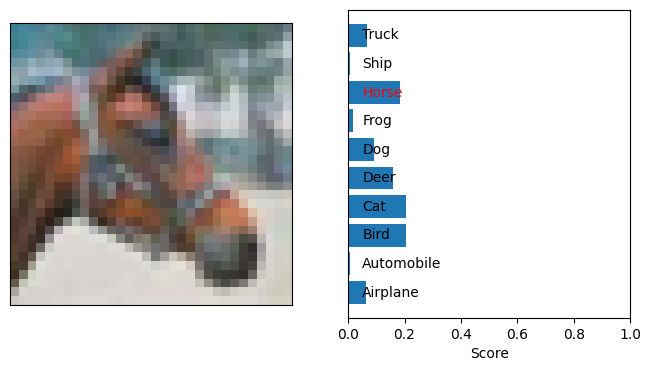

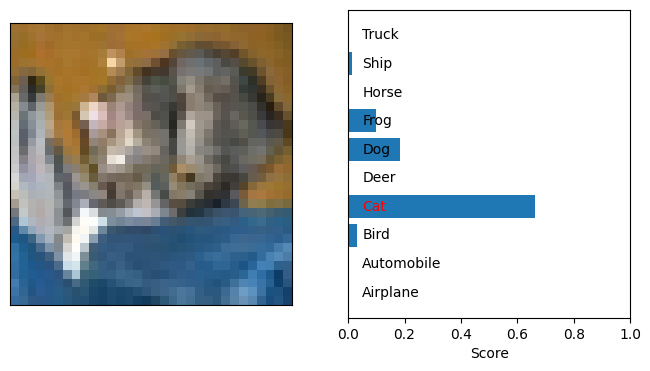

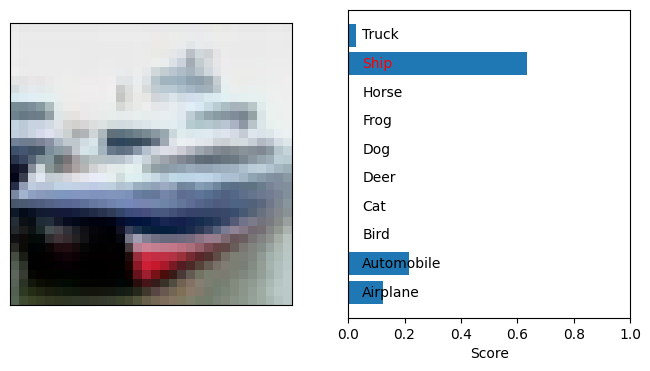

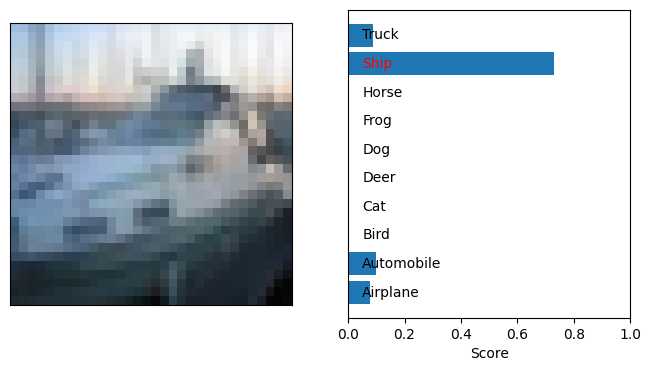

In [ ]:
# ----------------------------------------------------------
# Plots
# ----------------------------------------------------------
# training curves
history = np.genfromtxt("history_{}.csv".format(model.name), delimiter=",", names=True)


# Hint: this is how you can plot the confusion matrix.
# calculate predictions for test set
y_predict = model.predict(x_test_norm, batch_size=128)

# convert back to class labels (0-9)
y_predict_cl = np.argmax(y_predict, axis=1)
y_test_cl = np.argmax(y_test_onehot, axis=1)

# plot confusion matrix
plot_confusion(y_test_cl, y_predict_cl)

#
test_acc=np.mean(np.equal(y_predict_cl, y_test_cl))
print(test_acc)

# Task: plot a few examples of correctly and incorrectly classified images.
# Hint: First find the indices of correctly and incorrectly classified images:
i0 = np.argwhere(y_predict_cl != y_test_cl)  # misclassified images
i1 = np.argwhere(y_predict_cl == y_test_cl)  # correctly classified images

# original (unnormalized) test images
x_test = x_test[:8000]

# Hint: Now you can use the `plot_prediction` function to plot the images:
# plot first 3 false classifications
for i in i0[0:3]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])

#Plot correct classifications:
for i in i1[0:3]:
    plot_prediction(x_test[i], y_test_onehot[i], y_predict[i])


## Note
train accuracy: 64%, validation accuracy: 59%, test accuracy: 62%. Much better test accuracy now=better model with cnn.